In [1]:
import decimal
from collections import defaultdict
import matplotlib
import numpy as np
import itertools
import os
import pandas as pd
import datetime
from joblib import dump
import json
from matplotlib import pyplot as plt
from tqdm import tqdm
import glob
import pdb
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import fbeta_score, classification_report, confusion_matrix
from catboost import CatBoostClassifier
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import roc_curve, auc
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.insert(0, '../../scripts/modeling_toolbox/')
sys.path.insert(0, '../../scripts/asset_processor/')
import utils
from video_asset_processor import VideoAssetProcessor

%matplotlib notebook
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize']=[10,6]
pd.options.display.width = 0
pd.set_option('display.max_columns', None)

In [2]:
%matplotlib notebook

In [19]:
FEATURES_UL = ['size_dimension_ratio',
               'temporal_dct-mean',
               'temporal_gaussian_mse-mean',
               'temporal_gaussian_difference-mean',
               'temporal_threshold_gaussian_difference-mean'
               ]

FEATURES_SL = ['temporal_dct-mean',
               'temporal_gaussian_mse-mean',
               'temporal_gaussian_difference-mean',
               'temporal_threshold_gaussian_difference-mean'
               ]
FEATURES_QOE = ['temporal_dct-mean',
            'temporal_gaussian_mse-mean',
            'temporal_gaussian_difference-mean',
            'temporal_threshold_gaussian_difference-mean'
            ]
FEATURES_META = ['cat_r_pred','cat_cl_pred','ocsvm_pred']
METRICS_QOE = ['temporal_ssim-mean']
FULL_FEATURES = list(set(FEATURES_UL+FEATURES_SL+FEATURES_QOE+METRICS_QOE)-{'size_dimension_ratio'})
# Target variable, 1 represents Tamper, 0 is correct rendition
TARGET = ['target']

train_fraction = 0.85

In [4]:
# read data
data = utils.load_data('../../../data/data-large.csv')
len_before = len(data)

In [5]:
# drop all columns without some of the features
data.dropna(axis=0, subset=FEATURES_SL+FEATURES_UL+FEATURES_QOE+METRICS_QOE, inplace=True)
print(f'Removed {len_before - len(data)} NA rows')

Removed 15192 NA rows


In [6]:
# split test and train
np.random.seed(1337)
train_data = data.sample(frac=train_fraction)
test_data = data[~data.index.isin(train_data.index)]
y_test = test_data['target']
y_train = train_data['target']

In [7]:
# renditions by type
print('Test data top rendition types:')
test_data.groupby('rendition').rendition.count().sort_values().tail(15)

Test data top rendition types:


rendition
240p_watermark-345x114       535
360p_rotate_90_clockwise     535
360p_vignette                535
240p_low_bitrate_8           537
480p_rotate_90_clockwise     544
144p_low_bitrate_4           545
480p_watermark               546
240p_vignette                546
1080p_low_bitrate_4          546
144p_vignette                547
360p_watermark-856x856       549
1080p_rotate_90_clockwise    549
360p_low_bitrate_4           554
480p_low_bitrate_8           556
240p                         573
Name: rendition, dtype: int64

In [8]:
# class balance, 1 is tampered rendition, 0 is accurate rendition
print('Test data class balance:')
test_data.groupby('target').target.count()

Test data class balance:


target
0     2741
1    25763
Name: target, dtype: int64

In [9]:
# test renditions by type
print('Test data FPS renditions count:')
test_data[test_data.rendition.str.contains('fps')].groupby('rendition').rendition.count().sum()

Test data FPS renditions count:


829

In [10]:
### OCSVM MODEL
# fit outlier detector to untampered videos
x_train_ul = np.asarray(train_data[FEATURES_UL][train_data.target==0])
x_test_ul = np.asarray(test_data[FEATURES_UL])
# scale the data
scaler = StandardScaler()
x_train_ul = scaler.fit_transform(x_train_ul)
x_test_ul = scaler.transform(x_test_ul)
# fit the model
oc_svm = svm.OneClassSVM(kernel='rbf', gamma=0.3, nu=0.001, cache_size=5000)
oc_svm.fit(x_train_ul)
def ocsvm_score_converter(score):
    return 1-1/(1+np.exp(-score))
# get predictions on test and convert them with sigmoid function to (0,1) interval
test_data['ocsvm_pred'] = ocsvm_score_converter(oc_svm.decision_function(x_test_ul))
# add predictions to train data
train_data['ocsvm_pred'] = ocsvm_score_converter(oc_svm.decision_function(np.asarray(train_data[FEATURES_UL])))
# dump scaler and model
dump(scaler, '../output/models/UL_StandardScaler.joblib')
dump(oc_svm, '../output/models/OCSVM.joblib')

['../output/models/OCSVM.joblib']

In [11]:
### CATBOOST MODEL
cat_features = []
# Initialize CatBoostClassifier
cb_params = dict(iterations=500,
                 learning_rate=0.05,
                 depth=6)
catboost_binary = CatBoostClassifier(**cb_params)
# Fit model
cat_x_train = np.asarray(train_data[FEATURES_SL])
catboost_binary.fit(cat_x_train, train_data['target'], cat_features)
cat_x_test = np.asarray(test_data[FEATURES_SL])
test_data['cat_cl_pred'] = catboost_binary.predict_proba(cat_x_test)[:,1]
# add predictions to train data
train_data['cat_cl_pred'] = catboost_binary.predict_proba(cat_x_train)[:,1]
catboost_binary.save_model('../output/models/CB_Binary.cbm',
                           format="cbm",
                           export_parameters=None,
                           pool=None)


0:	learn: 0.5934404	total: 58.8ms	remaining: 29.4s
1:	learn: 0.5079491	total: 70.8ms	remaining: 17.6s
2:	learn: 0.4408453	total: 82.7ms	remaining: 13.7s
3:	learn: 0.3897194	total: 94.7ms	remaining: 11.7s
4:	learn: 0.3507658	total: 107ms	remaining: 10.6s
5:	learn: 0.3152917	total: 119ms	remaining: 9.76s
6:	learn: 0.2878546	total: 130ms	remaining: 9.19s
7:	learn: 0.2678674	total: 142ms	remaining: 8.75s
8:	learn: 0.2537132	total: 154ms	remaining: 8.4s
9:	learn: 0.2416089	total: 166ms	remaining: 8.13s
10:	learn: 0.2325281	total: 179ms	remaining: 7.94s
11:	learn: 0.2242413	total: 190ms	remaining: 7.73s
12:	learn: 0.2173499	total: 202ms	remaining: 7.56s
13:	learn: 0.2111630	total: 213ms	remaining: 7.4s
14:	learn: 0.2066487	total: 225ms	remaining: 7.28s
15:	learn: 0.2030834	total: 237ms	remaining: 7.17s
16:	learn: 0.1972780	total: 248ms	remaining: 7.04s
17:	learn: 0.1932950	total: 270ms	remaining: 7.23s
18:	learn: 0.1899770	total: 290ms	remaining: 7.33s
19:	learn: 0.1872319	total: 301ms	remai

168:	learn: 0.1489606	total: 2.57s	remaining: 5.03s
169:	learn: 0.1489461	total: 2.6s	remaining: 5.05s
170:	learn: 0.1489194	total: 2.63s	remaining: 5.05s
171:	learn: 0.1488785	total: 2.65s	remaining: 5.05s
172:	learn: 0.1488412	total: 2.68s	remaining: 5.07s
173:	learn: 0.1488058	total: 2.71s	remaining: 5.07s
174:	learn: 0.1487890	total: 2.73s	remaining: 5.08s
175:	learn: 0.1487522	total: 2.76s	remaining: 5.09s
176:	learn: 0.1487215	total: 2.8s	remaining: 5.11s
177:	learn: 0.1486816	total: 2.82s	remaining: 5.11s
178:	learn: 0.1486682	total: 2.85s	remaining: 5.11s
179:	learn: 0.1486278	total: 2.88s	remaining: 5.11s
180:	learn: 0.1485811	total: 2.9s	remaining: 5.11s
181:	learn: 0.1485587	total: 2.93s	remaining: 5.11s
182:	learn: 0.1485139	total: 2.95s	remaining: 5.11s
183:	learn: 0.1485016	total: 2.97s	remaining: 5.1s
184:	learn: 0.1484805	total: 2.98s	remaining: 5.08s
185:	learn: 0.1484309	total: 3.01s	remaining: 5.08s
186:	learn: 0.1483692	total: 3.03s	remaining: 5.07s
187:	learn: 0.14

339:	learn: 0.1444453	total: 5.71s	remaining: 2.69s
340:	learn: 0.1444191	total: 5.73s	remaining: 2.67s
341:	learn: 0.1443886	total: 5.75s	remaining: 2.65s
342:	learn: 0.1443601	total: 5.76s	remaining: 2.64s
343:	learn: 0.1443512	total: 5.78s	remaining: 2.62s
344:	learn: 0.1443411	total: 5.79s	remaining: 2.6s
345:	learn: 0.1443118	total: 5.8s	remaining: 2.58s
346:	learn: 0.1442927	total: 5.82s	remaining: 2.57s
347:	learn: 0.1442615	total: 5.84s	remaining: 2.55s
348:	learn: 0.1442488	total: 5.85s	remaining: 2.53s
349:	learn: 0.1442381	total: 5.87s	remaining: 2.51s
350:	learn: 0.1442181	total: 5.88s	remaining: 2.5s
351:	learn: 0.1442088	total: 5.9s	remaining: 2.48s
352:	learn: 0.1441935	total: 5.91s	remaining: 2.46s
353:	learn: 0.1441693	total: 5.93s	remaining: 2.44s
354:	learn: 0.1441576	total: 5.94s	remaining: 2.43s
355:	learn: 0.1441300	total: 5.96s	remaining: 2.41s
356:	learn: 0.1441055	total: 5.98s	remaining: 2.39s
357:	learn: 0.1440869	total: 5.99s	remaining: 2.38s
358:	learn: 0.14

In [12]:
### CATBOOST QOE REGRESSOR
categorical_features_indices = []

train_pool = Pool(data=train_data[FEATURES_QOE],
                  label=train_data[METRICS_QOE],
                  cat_features=categorical_features_indices)

loss_funct = 'MAE'
cb_params = {'depth':6,
             'num_trees':100,
             'l2_leaf_reg':5,
             'learning_rate':0.05,
             'loss_function':loss_funct}
model_catboost_regressor = CatBoostRegressor(**cb_params)

#Train the model
print('Training QoE model:')
model_catboost_regressor.fit(train_pool)
train_data['cat_r_pred'] = model_catboost_regressor.predict(train_data[FEATURES_QOE])
test_data['cat_r_pred'] = model_catboost_regressor.predict(test_data[FEATURES_QOE])

Training QoE model:
0:	learn: 0.1411661	total: 19.1ms	remaining: 1.89s
1:	learn: 0.1363182	total: 35.2ms	remaining: 1.72s
2:	learn: 0.1319278	total: 49.9ms	remaining: 1.61s
3:	learn: 0.1274811	total: 64.6ms	remaining: 1.55s
4:	learn: 0.1234209	total: 79.4ms	remaining: 1.51s
5:	learn: 0.1198892	total: 94.2ms	remaining: 1.48s
6:	learn: 0.1165877	total: 109ms	remaining: 1.45s
7:	learn: 0.1132374	total: 125ms	remaining: 1.44s
8:	learn: 0.1101363	total: 142ms	remaining: 1.44s
9:	learn: 0.1072008	total: 161ms	remaining: 1.45s
10:	learn: 0.1046177	total: 177ms	remaining: 1.43s
11:	learn: 0.1018924	total: 192ms	remaining: 1.41s
12:	learn: 0.0994523	total: 207ms	remaining: 1.39s
13:	learn: 0.0972159	total: 223ms	remaining: 1.37s
14:	learn: 0.0949897	total: 238ms	remaining: 1.35s
15:	learn: 0.0931324	total: 253ms	remaining: 1.33s
16:	learn: 0.0912344	total: 268ms	remaining: 1.31s
17:	learn: 0.0894026	total: 283ms	remaining: 1.29s
18:	learn: 0.0877210	total: 298ms	remaining: 1.27s
19:	learn: 0.08

In [13]:
### META MODEL
cat_features = []
# Initialize CatBoostClassifier
cb_params = dict(iterations=500,
                 learning_rate=0.05,
                 depth=6)
catboost_meta = CatBoostClassifier(**cb_params)
# Fit model
meta_x_train = np.asarray(train_data[FEATURES_META])
catboost_meta.fit(meta_x_train, train_data['target'], cat_features)
meta_x_test = np.asarray(test_data[FEATURES_META])
meta_y_test_pred = catboost_meta.predict_proba(meta_x_test)[:,1]
test_data['meta_y_pred'] = catboost_meta.predict_proba(meta_x_test)[:,1]
catboost_meta.save_model('../output/models/CB_Meta.cbm',
                           format="cbm",
                           export_parameters=None,
                           pool=None)

0:	learn: 0.6216818	total: 11.7ms	remaining: 5.84s
1:	learn: 0.5387618	total: 27.6ms	remaining: 6.88s
2:	learn: 0.4692892	total: 41.5ms	remaining: 6.88s
3:	learn: 0.4078265	total: 54.5ms	remaining: 6.76s
4:	learn: 0.3513201	total: 66.5ms	remaining: 6.59s
5:	learn: 0.3244090	total: 78.8ms	remaining: 6.49s
6:	learn: 0.3040325	total: 88.7ms	remaining: 6.25s
7:	learn: 0.2756654	total: 101ms	remaining: 6.19s
8:	learn: 0.2484572	total: 113ms	remaining: 6.18s
9:	learn: 0.2298455	total: 127ms	remaining: 6.2s
10:	learn: 0.2172893	total: 140ms	remaining: 6.21s
11:	learn: 0.2019331	total: 154ms	remaining: 6.25s
12:	learn: 0.1946562	total: 167ms	remaining: 6.26s
13:	learn: 0.1852026	total: 180ms	remaining: 6.26s
14:	learn: 0.1810613	total: 195ms	remaining: 6.32s
15:	learn: 0.1777587	total: 214ms	remaining: 6.47s
16:	learn: 0.1742695	total: 234ms	remaining: 6.64s
17:	learn: 0.1699642	total: 249ms	remaining: 6.67s
18:	learn: 0.1651914	total: 263ms	remaining: 6.65s
19:	learn: 0.1616481	total: 277ms	r

168:	learn: 0.1399255	total: 2.48s	remaining: 4.85s
169:	learn: 0.1399236	total: 2.5s	remaining: 4.84s
170:	learn: 0.1399173	total: 2.51s	remaining: 4.83s
171:	learn: 0.1399136	total: 2.52s	remaining: 4.81s
172:	learn: 0.1399125	total: 2.54s	remaining: 4.8s
173:	learn: 0.1399083	total: 2.55s	remaining: 4.78s
174:	learn: 0.1399079	total: 2.56s	remaining: 4.76s
175:	learn: 0.1399035	total: 2.58s	remaining: 4.74s
176:	learn: 0.1399033	total: 2.59s	remaining: 4.72s
177:	learn: 0.1398976	total: 2.6s	remaining: 4.71s
178:	learn: 0.1398938	total: 2.61s	remaining: 4.69s
179:	learn: 0.1398895	total: 2.63s	remaining: 4.67s
180:	learn: 0.1398842	total: 2.64s	remaining: 4.65s
181:	learn: 0.1398818	total: 2.65s	remaining: 4.63s
182:	learn: 0.1398793	total: 2.67s	remaining: 4.62s
183:	learn: 0.1398741	total: 2.68s	remaining: 4.6s
184:	learn: 0.1398710	total: 2.7s	remaining: 4.59s
185:	learn: 0.1398675	total: 2.71s	remaining: 4.58s
186:	learn: 0.1398672	total: 2.73s	remaining: 4.56s
187:	learn: 0.139

340:	learn: 0.1393813	total: 4.96s	remaining: 2.31s
341:	learn: 0.1393810	total: 4.98s	remaining: 2.3s
342:	learn: 0.1393807	total: 4.99s	remaining: 2.28s
343:	learn: 0.1393804	total: 5s	remaining: 2.27s
344:	learn: 0.1393801	total: 5.02s	remaining: 2.25s
345:	learn: 0.1393799	total: 5.03s	remaining: 2.24s
346:	learn: 0.1393797	total: 5.04s	remaining: 2.22s
347:	learn: 0.1393795	total: 5.06s	remaining: 2.21s
348:	learn: 0.1393793	total: 5.07s	remaining: 2.19s
349:	learn: 0.1393791	total: 5.09s	remaining: 2.18s
350:	learn: 0.1393790	total: 5.1s	remaining: 2.16s
351:	learn: 0.1393788	total: 5.11s	remaining: 2.15s
352:	learn: 0.1393787	total: 5.13s	remaining: 2.13s
353:	learn: 0.1393785	total: 5.14s	remaining: 2.12s
354:	learn: 0.1393784	total: 5.15s	remaining: 2.1s
355:	learn: 0.1393783	total: 5.17s	remaining: 2.09s
356:	learn: 0.1393782	total: 5.18s	remaining: 2.08s
357:	learn: 0.1393781	total: 5.2s	remaining: 2.06s
358:	learn: 0.1393780	total: 5.21s	remaining: 2.05s
359:	learn: 0.13937

In [21]:
### FULL FEATURE CATBOOST MODEL
cat_features = []
# Initialize CatBoostClassifier
cb_params = dict(iterations=500,
                 learning_rate=0.05,
                 depth=6)
catboost_full = CatBoostClassifier(**cb_params)
# Fit model
full_x_train = np.asarray(train_data[FULL_FEATURES])
catboost_full.fit(full_x_train, train_data['target'], cat_features)
full_x_test = np.asarray(test_data[FULL_FEATURES])
full_y_test_pred = catboost_meta.predict_proba(full_x_test)[:,1]
test_data['full_y_pred'] = catboost_full.predict_proba(full_x_test)[:,1]
catboost_full.save_model('../output/models/CB_Full.cbm',
                           format="cbm",
                           export_parameters=None,
                           pool=None)

0:	learn: 0.5842703	total: 12ms	remaining: 6.01s
1:	learn: 0.5153940	total: 24.2ms	remaining: 6.01s
2:	learn: 0.4638559	total: 35.6ms	remaining: 5.89s
3:	learn: 0.4157801	total: 47.5ms	remaining: 5.89s
4:	learn: 0.3736020	total: 59ms	remaining: 5.84s
5:	learn: 0.3345010	total: 70.9ms	remaining: 5.84s
6:	learn: 0.3078279	total: 83ms	remaining: 5.84s
7:	learn: 0.2877582	total: 94.8ms	remaining: 5.83s
8:	learn: 0.2714890	total: 107ms	remaining: 5.82s
9:	learn: 0.2518266	total: 119ms	remaining: 5.84s
10:	learn: 0.2373608	total: 132ms	remaining: 5.85s
11:	learn: 0.2305015	total: 143ms	remaining: 5.83s
12:	learn: 0.2228372	total: 155ms	remaining: 5.82s
13:	learn: 0.2156950	total: 167ms	remaining: 5.81s
14:	learn: 0.2081793	total: 179ms	remaining: 5.79s
15:	learn: 0.2041577	total: 191ms	remaining: 5.79s
16:	learn: 0.1985103	total: 204ms	remaining: 5.8s
17:	learn: 0.1958687	total: 225ms	remaining: 6.03s
18:	learn: 0.1916856	total: 242ms	remaining: 6.13s
19:	learn: 0.1876847	total: 254ms	remain

169:	learn: 0.1446279	total: 2.28s	remaining: 4.42s
170:	learn: 0.1445961	total: 2.29s	remaining: 4.41s
171:	learn: 0.1445397	total: 2.31s	remaining: 4.4s
172:	learn: 0.1445016	total: 2.32s	remaining: 4.38s
173:	learn: 0.1444871	total: 2.33s	remaining: 4.36s
174:	learn: 0.1444469	total: 2.34s	remaining: 4.35s
175:	learn: 0.1443518	total: 2.35s	remaining: 4.33s
176:	learn: 0.1442847	total: 2.37s	remaining: 4.32s
177:	learn: 0.1442666	total: 2.38s	remaining: 4.3s
178:	learn: 0.1442450	total: 2.39s	remaining: 4.29s
179:	learn: 0.1441943	total: 2.4s	remaining: 4.27s
180:	learn: 0.1441140	total: 2.42s	remaining: 4.26s
181:	learn: 0.1440940	total: 2.43s	remaining: 4.25s
182:	learn: 0.1440500	total: 2.44s	remaining: 4.23s
183:	learn: 0.1440023	total: 2.45s	remaining: 4.21s
184:	learn: 0.1439728	total: 2.47s	remaining: 4.2s
185:	learn: 0.1439079	total: 2.49s	remaining: 4.2s
186:	learn: 0.1438630	total: 2.5s	remaining: 4.19s
187:	learn: 0.1438418	total: 2.51s	remaining: 4.17s
188:	learn: 0.1437

333:	learn: 0.1389805	total: 4.78s	remaining: 2.38s
334:	learn: 0.1389441	total: 4.81s	remaining: 2.37s
335:	learn: 0.1389332	total: 4.84s	remaining: 2.36s
336:	learn: 0.1389110	total: 4.87s	remaining: 2.35s
337:	learn: 0.1388888	total: 4.89s	remaining: 2.34s
338:	learn: 0.1388677	total: 4.91s	remaining: 2.33s
339:	learn: 0.1388439	total: 4.94s	remaining: 2.32s
340:	learn: 0.1388126	total: 4.96s	remaining: 2.31s
341:	learn: 0.1387942	total: 4.98s	remaining: 2.3s
342:	learn: 0.1387686	total: 5s	remaining: 2.29s
343:	learn: 0.1387447	total: 5.02s	remaining: 2.28s
344:	learn: 0.1387023	total: 5.04s	remaining: 2.27s
345:	learn: 0.1386820	total: 5.06s	remaining: 2.25s
346:	learn: 0.1386604	total: 5.08s	remaining: 2.24s
347:	learn: 0.1386265	total: 5.1s	remaining: 2.23s
348:	learn: 0.1385899	total: 5.12s	remaining: 2.21s
349:	learn: 0.1385718	total: 5.13s	remaining: 2.2s
350:	learn: 0.1385501	total: 5.15s	remaining: 2.19s
351:	learn: 0.1385210	total: 5.17s	remaining: 2.17s
352:	learn: 0.1384

496:	learn: 0.1352093	total: 7.54s	remaining: 45.5ms
497:	learn: 0.1351698	total: 7.56s	remaining: 30.4ms
498:	learn: 0.1351391	total: 7.57s	remaining: 15.2ms
499:	learn: 0.1351299	total: 7.59s	remaining: 0us


In [24]:
def multi_model_perf(y, y_preds, labs, cols=['green', 'orange', 'red', 'black', 'blue', 'yellow', 'magenta'], report_threshold=0.5):
    plt.figure()
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Model ROC comparison')
    for y_pred, lab, col in zip(y_preds, labs, cols):
        fpr, tpr, thresh = roc_curve(y, y_pred, pos_label=1)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=col,
                 lw=2, label=lab+' AUC=%0.2f' % roc_auc)
        print('##################')
        print(f'{lab} ROC thresholds: {thresh}')
        print(f'{lab} classification report:')
        print(classification_report(y_test, y_pred>report_threshold))
        print(f'{lab} confusion matrix:')
        print(confusion_matrix(y_test, y_pred>report_threshold))
    plt.legend(loc="lower right")
    plt.show()

<IPython.core.display.Javascript object>


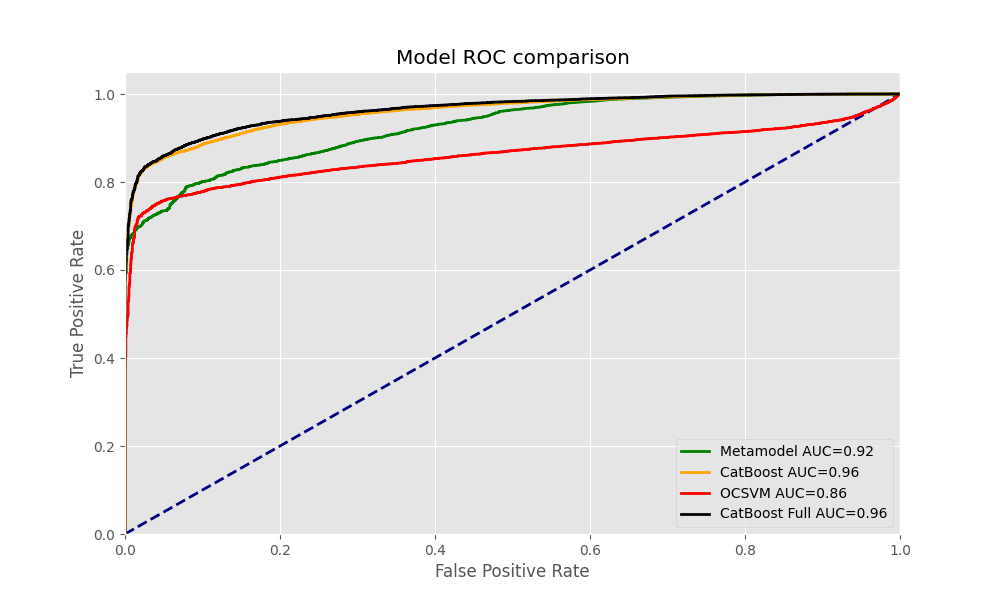

##################
Metamodel ROC thresholds: [1.99999932 0.99999932 0.99999932 ... 0.16977581 0.16767264 0.06333972]
Metamodel classification report:
              precision    recall  f1-score   support

           0       0.94      0.11      0.19      2741
           1       0.91      1.00      0.95     25763

    accuracy                           0.91     28504
   macro avg       0.92      0.55      0.57     28504
weighted avg       0.92      0.91      0.88     28504

Metamodel confusion matrix:
[[  289  2452]
 [   20 25743]]
##################
CatBoost ROC thresholds: [1.99999379 0.99999379 0.99999375 ... 0.01130785 0.01108088 0.00583929]
CatBoost classification report:
              precision    recall  f1-score   support

           0       0.72      0.49      0.58      2741
           1       0.95      0.98      0.96     25763

    accuracy                           0.93     28504
   macro avg       0.84      0.73      0.77     28504
weighted avg       0.93      0.93      0.93 

In [25]:
multi_model_perf(y_test, [test_data['meta_y_pred'], test_data['cat_cl_pred'], test_data['ocsvm_pred'],
                       test_data['full_y_pred']], 
              ['Metamodel','CatBoost', 'OCSVM',
               'CatBoost Full'])

In [17]:
print('Hardest rendition types:')
test_data['full_y_pred_lab'] = test_data['full_y_pred']>0.9
test_data[test_data.full_y_pred_lab!=test_data.target].groupby('rendition').rendition.count().sort_values().tail(15)

Hardest rendition types:


rendition
240p                        10
144p                        12
1080p_low_bitrate_4         13
360p                        15
360p_low_bitrate_4          16
240p_watermark              16
1080p_watermark-345x114     22
480p_low_bitrate_4          27
144p_watermark              32
720p_low_bitrate_4          33
720p_watermark-345x114      42
480p_watermark-345x114      63
360p_watermark-345x114      74
240p_watermark-345x114     120
144p_watermark-345x114     155
Name: rendition, dtype: int64

In [27]:
print('Feature importance:')
importance = catboost_full.get_feature_importance(prettified=True)
importance['Feature Name']=np.array(FULL_FEATURES)[importance['Feature Id'].values.astype(np.int32)]
importance

Feature importance:


,Feature Id,Importances,Feature Name
0,2,40.447926,temporal_gaussian_difference-mean
1,4,21.707936,temporal_gaussian_mse-mean
2,1,17.824943,temporal_dct-mean
3,3,10.009718,temporal_ssim-mean
4,0,10.009478,temporal_threshold_gaussian_difference-mean
